# Image Captioning Models for Flashcard Question Generation from PDF Slides

In this Notebook, the Image captioning models:
- Microsoft/git-base
- nlpconnect/vit-gpt2-image-captioning

are implemented and Fine-Tuned for Flashcard Question Generation on the synthetic Anki Data PDF Slide deck.

## Create Images and labels for Training
Using the PDF Extractor src content from ankinator main

In [1]:
from src.extraction.pdf_extractor import extract_text
from pypdfium2 import PdfDocument


slide_path = "datasets/synthetic_slides/pdf/render_2_230.pdf"
pdf = PdfDocument(slide_path)

text = extract_text(pdf.raw, None)
text[:5]

[(0,
  'Unrelated Title\r\n\ufffe\r\n• Transparency Inspec\ufffeon Adapta\ufffeon\r\n\ufffe/\ufffe\ufffe\ufffe\ufffe',
  '',
  <PIL.Image.Image image mode=RGB size=908x511>),
 (1,
  'Unrelated Title\r\n\ufffe\r\n• Product Owner (PO) Scrum Master (SM) Development Team (DT)\r\n\ufffe/\ufffe\ufffe\ufffe\ufffe',
  '',
  <PIL.Image.Image image mode=RGB size=908x511>),
 (2,
  'Unrelated Title\r\n\ufffe\r\n• Sprint Planning Daily Scrum Sprint review Sprint Retrospec\ufffeve\r\n\ufffe/\ufffe\ufffe\ufffe\ufffe',
  '',
  <PIL.Image.Image image mode=RGB size=908x511>),
 (3,
  'Unrelated Title\r\n\ufffe\r\n• Product Backlog Product Burn-up/down chart Sprint Backlog Sprint Burn-up/down\r\nchart\r\n\ufffe/\ufffe\ufffe\ufffe\ufffe',
  '',
  <PIL.Image.Image image mode=RGB size=908x511>),
 (4,
  'Unrelated Title\r\n\ufffe\r\n• Translate the business needs in the product backlog\r\n\ufffe/\ufffe\ufffe\ufffe\ufffe',
  '',
  <PIL.Image.Image image mode=RGB size=908x511>)]

In [2]:
from tqdm import tqdm

for slide in tqdm(text):
    slide[3].save(f"datasets/synthetic_slides/png/slide_{slide[0]}.png")

100%|██████████| 230/230 [00:03<00:00, 66.63it/s]


In [22]:
# Generate Labels
import pandas as pd
import swifter
from bs4 import BeautifulSoup

df = pd.read_csv("datasets/synthetic_slides/data.csv")
df["Questions"] = df["nflds"].swifter.apply(lambda x: x.split("',")[0].strip("[").strip("'") if "'," in x else x.split('",')[0].strip("[").strip('"'))
df["Questions"] = df["Questions"].swifter.apply(lambda x: BeautifulSoup(x, features="lxml").text)
df["file_name"] = [f"slide_{i}.png" for i in df.index]
df.drop(columns=["nid", "nflds", "answer", "images"], inplace=True)
df[:230].to_csv("datasets/synthetic_slides/png/metadata.csv", index=False)
df[:230]

Pandas Apply:   0%|          | 0/4598 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4598 [00:00<?, ?it/s]

/scratch/slurm_tmpdir/job_22424503/ipykernel_300011/3841208505.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df["Questions"] = df["Questions"].swifter.apply(lambda x: BeautifulSoup(x, features="lxml").text)


,Questions,file_name
0,What is the Scrum process Framework,slide_0.png
1,What are the roles in scrum,slide_1.png
2,What are the events in Scrum,slide_2.png
3,What are the artifacts in Scrum,slide_3.png
4,What's the main role of the Product Owner,slide_4.png
...,...,...
225,How do you evaluate clustering quality (withou...,slide_225.png
226,"What is A/B testing, statistically speaking?Ho...",slide_226.png
227,Significance test for binary (binomial) outcom...,slide_227.png
228,Significance test for a continuous (normal-ish...,slide_228.png


## nlpconnect/vit-gpt2-image-captioning

Inference example from Huggingface:

In [ ]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [8]:
max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds

In [1]:

image_paths = ['./datasets/examples/bruchtal.jpeg', './datasets/examples/ducks.jpeg', './datasets/examples/Jacobian.png']
predictions = predict_step(image_paths) # ['a woman in a hospital bed with a woman in a hospital bed']


2023-07-12 16:05:01.095370: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-12 16:05:01.142739: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 16:05:02.355136: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of the model checkpoint at nlpconnect/vit-gpt2-image-captioning were not used when initializing VisionEncoderDecoderModel: ['decoder.transformer.h.9.crossattention.masked_bias', 'decoder.transformer.h.8.attn.bias', 'decoder.transformer.h

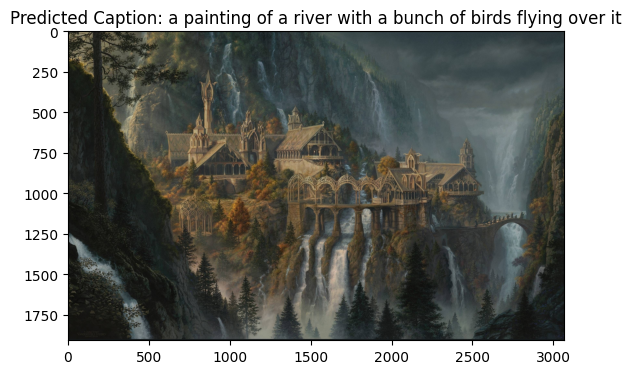

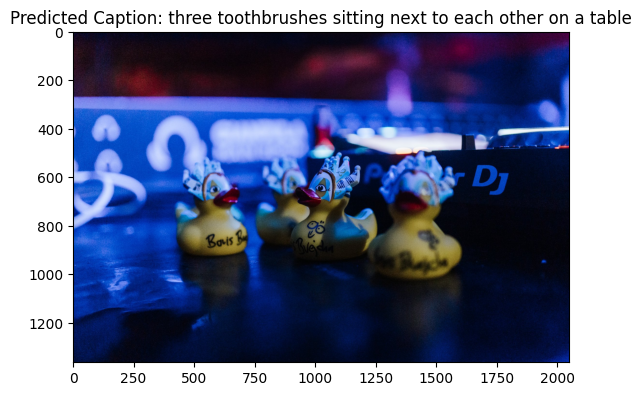

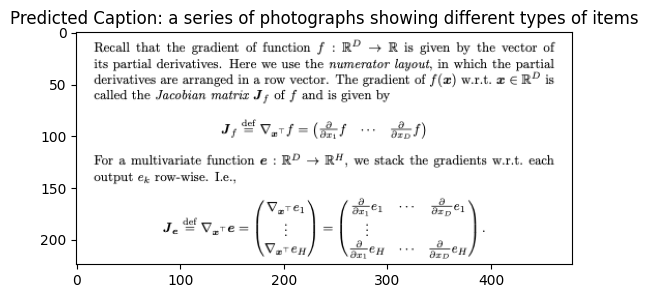

In [2]:
# Printing the images with the captions
import matplotlib.pyplot as plt
import numpy as np

for i, image in enumerate(image_paths):
    img = Image.open(image)
    img_arr = np.asarray(img)
    plt.imshow(img_arr)
    plt.title(f"Predicted Caption: {predictions[i]}")
    plt.show()

### Data Preprocessing

Resolving data files:   0%|          | 0/231 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/ma/ma_ma/ma_lknorr/.cache/huggingface/datasets/imagefolder/default-d3a5dce8a8564fd2/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

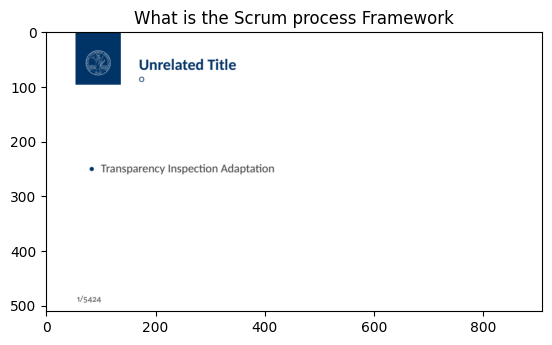

In [1]:
from datasets import load_dataset
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt

dataset = load_dataset("imagefolder", data_dir="datasets/synthetic_slides/png/")
plt.imshow(dataset["train"][0]["image"])
plt.title(dataset["train"][0]["Questions"])
plt.show()

In [2]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

2023-07-12 17:27:12.585061: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-12 17:27:12.629428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 17:27:13.669464: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of the model checkpoint at nlpconnect/vit-gpt2-image-captioning were not used when initializing VisionEncoderDecoderModel: ['decoder.transformer.h.8.attn.masked_bias', 'decoder.transformer.h.6.attn.bias', 'decoder.transformer.h.10.attn.m

In [3]:
def preprocess(samples, max_target_length):
    """ Preprocess the dataset to be used with vit-gpt2 """
    images = samples["image"]
    questions = samples["Questions"]
    
    return {
        "labels": tokenizer(questions, padding="max_length", max_length=max_target_length).input_ids,
        "pixel_values": feature_extractor(images=images, return_tensors="np").pixel_values
    }

dataset = dataset.filter(lambda sample: sample["Questions"] is not None) # Filter None Values
dataset = dataset.map(
    function=preprocess,
    batched=True,
    fn_kwargs={"max_target_length": 128},
    remove_columns=dataset['train'].column_names
)
dataset

Loading cached processed dataset at /home/ma/ma_ma/ma_lknorr/.cache/huggingface/datasets/imagefolder/default-d3a5dce8a8564fd2/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-62bee323a1d831df.arrow
Loading cached processed dataset at /home/ma/ma_ma/ma_lknorr/.cache/huggingface/datasets/imagefolder/default-d3a5dce8a8564fd2/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-a86afb8c4034caf3.arrow


DatasetDict({
    train: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 229
    })
})

### Fine-Tuning

In [4]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="no",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    output_dir="./vit-gpt2-out"
)

In [5]:
from transformers import default_data_collator

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    args=training_args,
    train_dataset=dataset["train"],
    data_collator=default_data_collator
)
trainer.train()

/home/ma/ma_ma/ma_lknorr/.local/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=174, training_loss=0.3897446818735408, metrics={'train_runtime': 85.4688, 'train_samples_per_second': 8.038, 'train_steps_per_second': 2.036, 'total_flos': 1.2397869319952794e+17, 'train_loss': 0.3897446818735408, 'epoch': 3.0})

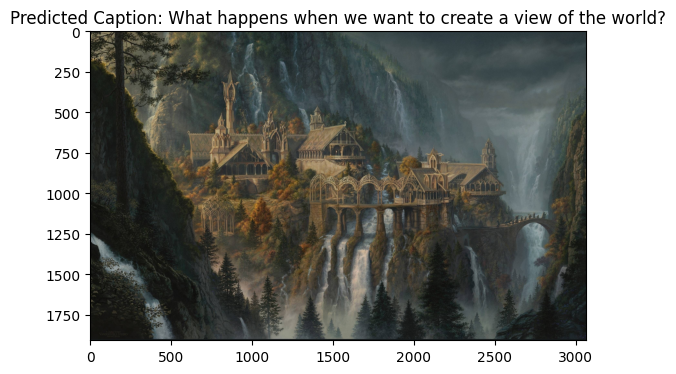

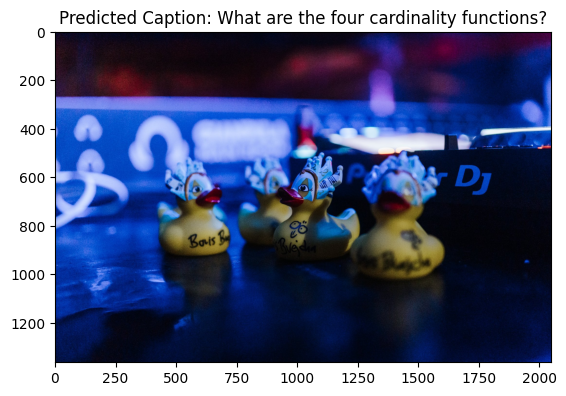

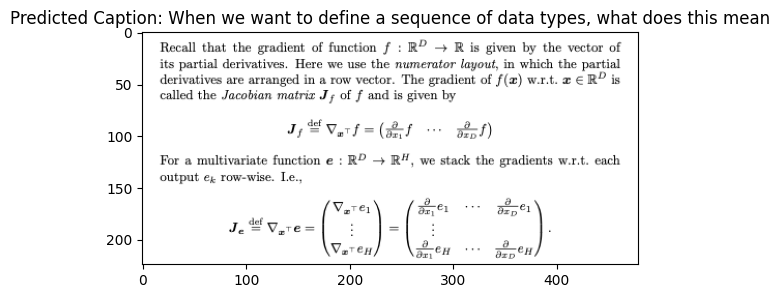

In [11]:
import numpy as np

model = trainer.model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

image_paths = ['./datasets/examples/bruchtal.jpeg', './datasets/examples/ducks.jpeg', './datasets/examples/Jacobian.png']
predictions = predict_step(image_paths)
for i, image in enumerate(image_paths):
    img = Image.open(image)
    img_arr = np.asarray(img)
    plt.imshow(img_arr)
    plt.title(f"Predicted Caption: {predictions[i]}")
    plt.show()